# CMS GIWAXS plotting notebook - plotting single images from loaded zarr datasets

## Imports

In [1]:
# Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
from tqdm.auto import tqdm

# Choose a colormap:
cmap = plt.cm.turbo
cmap.set_bad('black')

## Define & check paths

In [2]:
# I like pathlib for its readability & checkability, it's also necessary for the loadSeries function later on
# Replace the paths with the ones relevant to your data, you can use the ".exists()" method to make sure you defined a path correctly
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415')  # The proposals path is a good place to store large data (>1 TB space?)
outPath = propPath.joinpath('AL_processed_data')

samplesPath = outPath.joinpath('ex_situ_zarrs')

## Single image GIWAXS plotting

In [3]:
# List the files inside a folder
sorted([f.name for f in samplesPath.iterdir()])  # a way to list just the filenames and not the whole path

['caked_A1-3set-take2_waxs_stitched.zarr',
 'caked_A1-3set_waxs_stitched.zarr',
 'caked_PM6-Y6_waxs_stitched.zarr',
 'caked_bladecoated_films_waxs_stitched.zarr',
 'raw_A1-3set-take2_waxs_stitched.zarr',
 'raw_A1-3set_waxs_stitched.zarr',
 'raw_PM6-Y6_waxs_stitched.zarr',
 'raw_bladecoated_films_waxs_stitched.zarr',
 'recip_A1-3set-take2_waxs_stitched.zarr',
 'recip_A1-3set_waxs_stitched.zarr',
 'recip_PM6-Y6_waxs_stitched.zarr',
 'recip_bladecoated_films_waxs_stitched.zarr']

### 2D plots

#### Caked Images

In [4]:
filename = 'caked_PM6-Y6_waxs_stitched.zarr'
DS = xr.open_zarr(samplesPath.joinpath(filename))
DS = DS.where(DS>1e-5)
DS

<xarray.Dataset>
Dimensions:  (chi: 180, qr: 1000)
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.1393 0.1424 0.1455 0.1486 ... 3.226 3.229 3.232
Data variables: (12/18)
    1116469  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116470  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116471  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116475  (chi, qr) float32 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116476  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116477  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    ...       ...
    1116493  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116494  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116495  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116499  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116500  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116501  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>

In [5]:
# # How one could apply a sin chi correction
# sin_chi_DA = np.sin(np.radians(np.abs(DA.chi)))
# # sin_chi_DA

# corr_DA = DA * sin_chi_DA
# # corr_DA

In [6]:
# A way to select dataarrays based on attribute values:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['incident_angle'] == 'th0.120']
len(selected_DAs)

6

  0%|          | 0/6 [00:00<?, ?it/s]

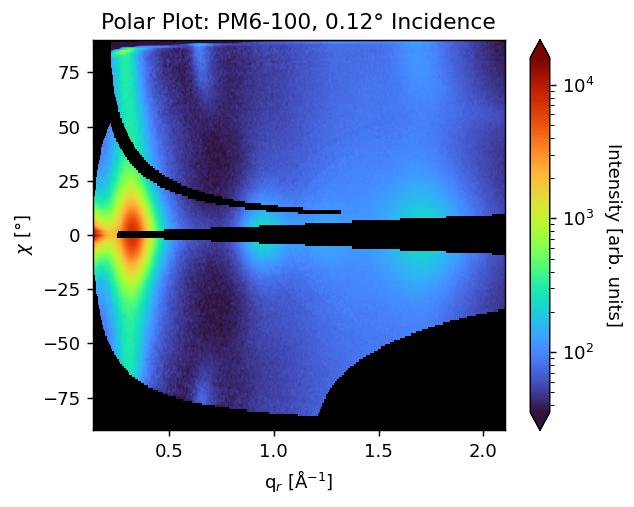

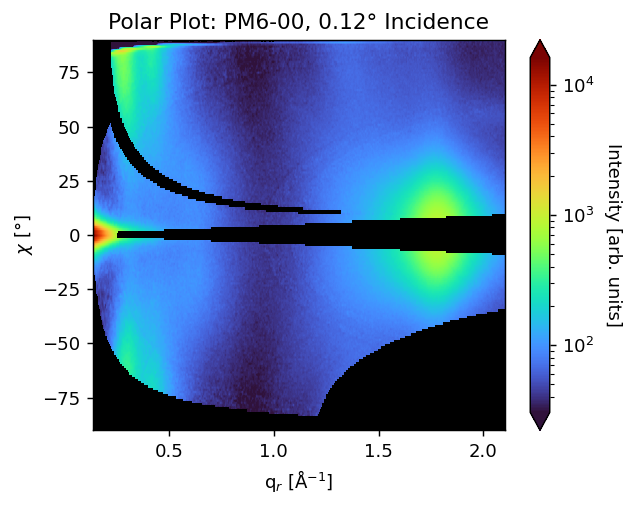

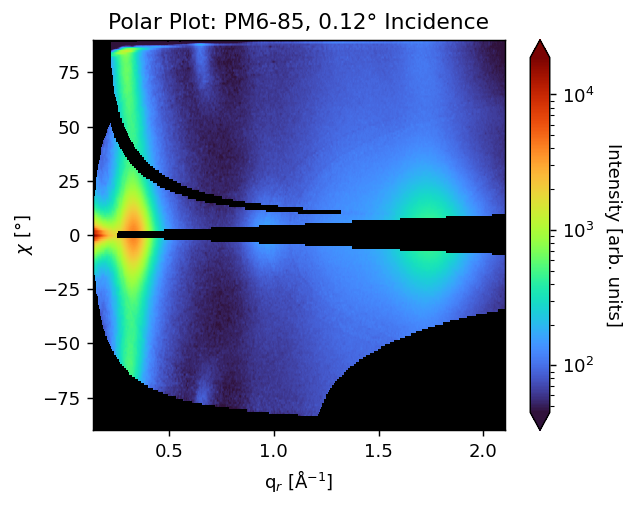

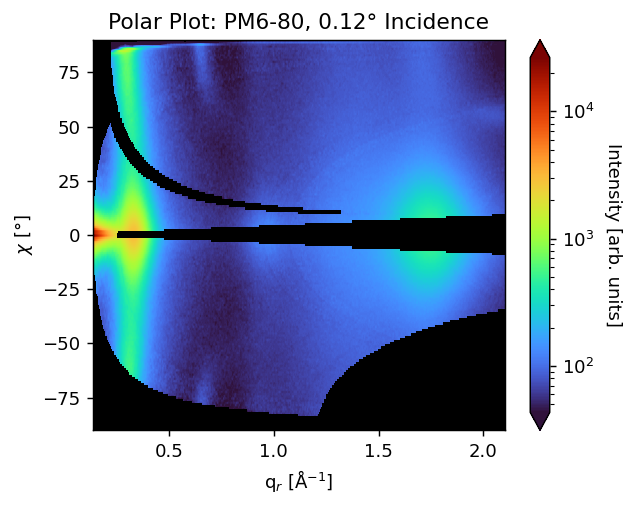

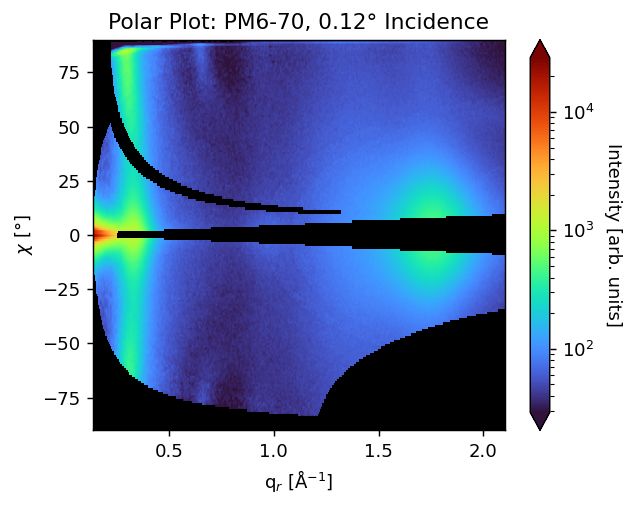

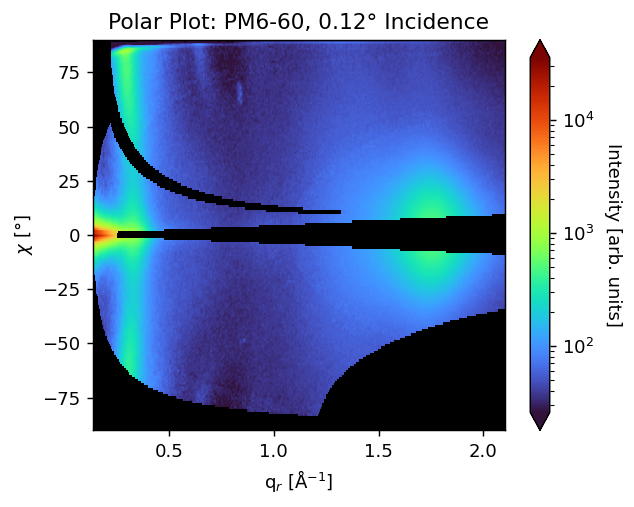

In [7]:
# Plot and optionally save selected dataarrays:
# Set chi range: Full range
chi_min = -90
chi_max = 90

for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(0,2.1))
    cmin = float(sliced_DA.compute().quantile(1e-2))  # Set color minimum value, based on quantile 
    cmax = float(sliced_DA.compute().quantile(1-1e-6))  # Set color maximum value, based on quantile
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=LogNorm(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(title=f'Polar Plot: {DA.polymer}-{DA.weight_percent}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(outPath.joinpath('PM6-Y6set_waxs', f'polar-2D_{DA.sample_id}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

  0%|          | 0/6 [00:00<?, ?it/s]

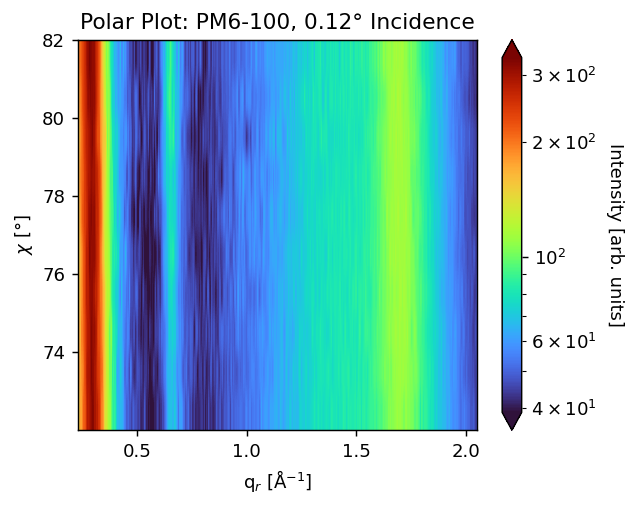

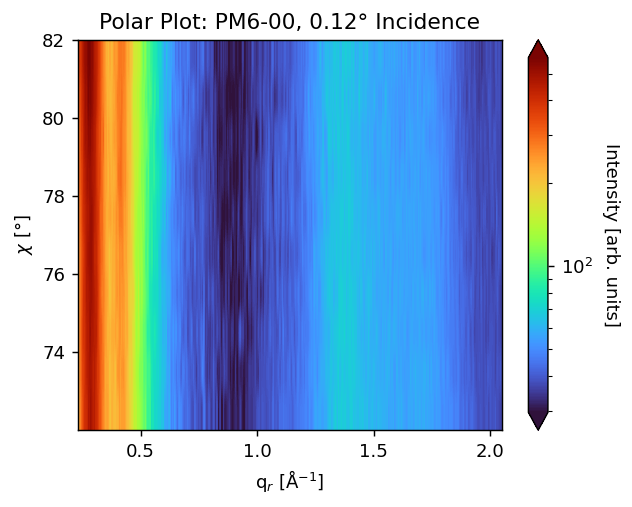

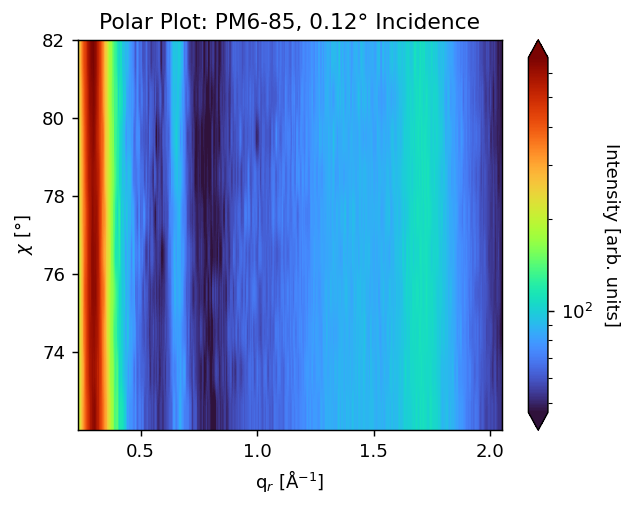

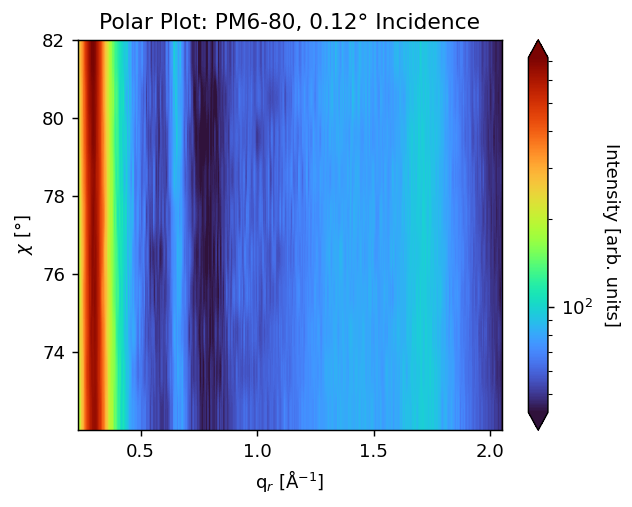

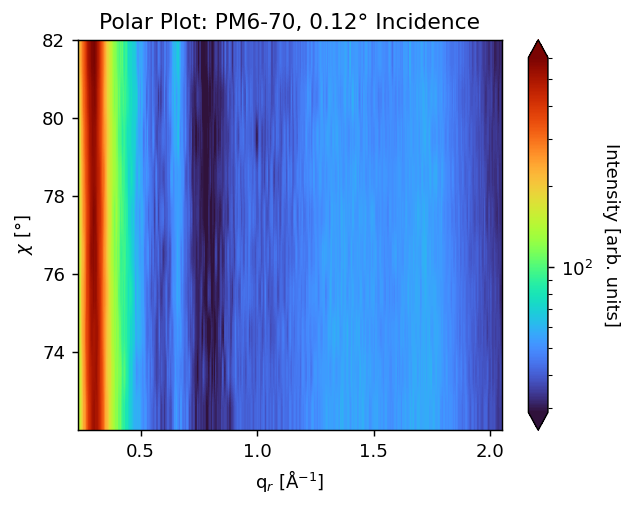

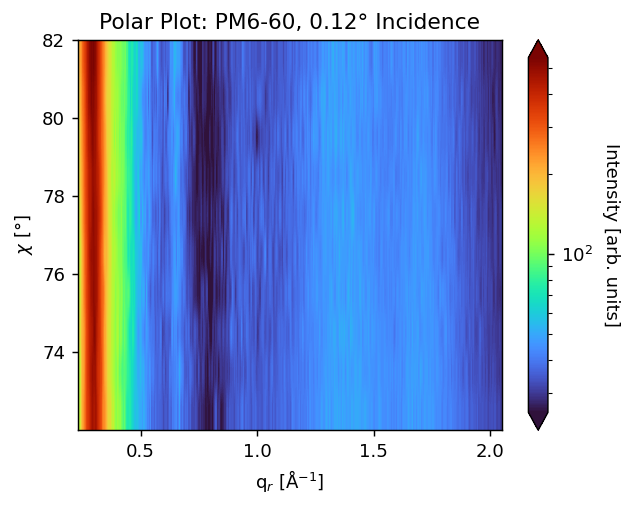

In [8]:
# Plot and optionally save selected dataarrays:
# Set chi range: In plane slice, choose a smooth section without detector gap/edge effects
chi_min = 72
chi_max = 82

for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(0.23,2.05))
    cmin = float(sliced_DA.compute().quantile(1e-2))  # Set color minimum value, based on quantile 
    cmax = float(sliced_DA.compute().quantile(1-1e-6))  # Set color maximum value, based on quantile
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=LogNorm(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(title=f'Polar Plot: {DA.polymer}-{DA.weight_percent}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(outPath.joinpath('PM6-Y6set_waxs', f'polar-2D_{DA.sample_id}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

In [9]:
# # A way to save data as csv files  
# for DA in DS.data_vars.values():
#     # qr columns, chi rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'polar-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

#### Reciprocal Space Images

In [10]:
filename = 'recip_PM6-Y6_waxs_stitched.zarr'
DS = xr.open_zarr(samplesPath.joinpath(filename))
DS = DS.where(DS>1e-5)
DS

<xarray.Dataset>
Dimensions:  (q_z: 1043, q_xy: 981)
Coordinates:
  * q_xy     (q_xy) float64 -1.219 -1.215 -1.212 -1.209 ... 2.171 2.175 2.178
  * q_z      (q_z) float64 0.007275 0.009704 0.01213 ... 2.534 2.537 2.539
Data variables: (12/18)
    1116469  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116470  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116471  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116475  (q_z, q_xy) float32 dask.array<chunksize=(261, 491), meta=np.ndarray>
    1116476  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116477  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    ...       ...
    1116493  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116494  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116495  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116499  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116500  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116501  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>

In [11]:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['incident_angle'] == 'th0.120']
len(selected_DAs)

6

  0%|          | 0/6 [00:00<?, ?it/s]

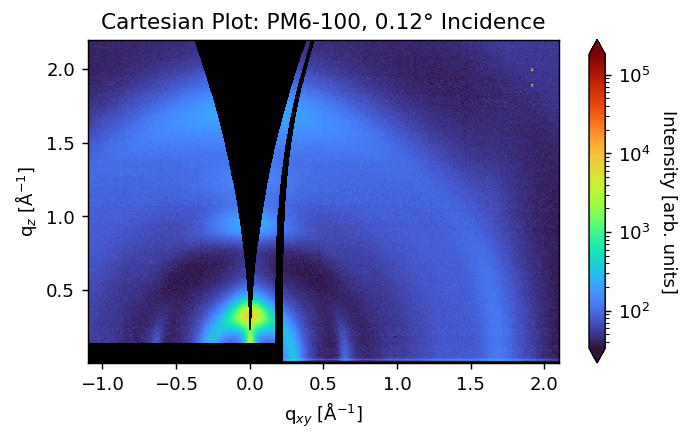

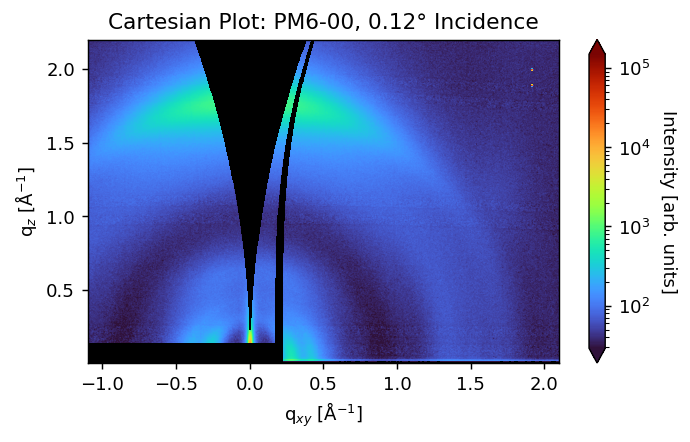

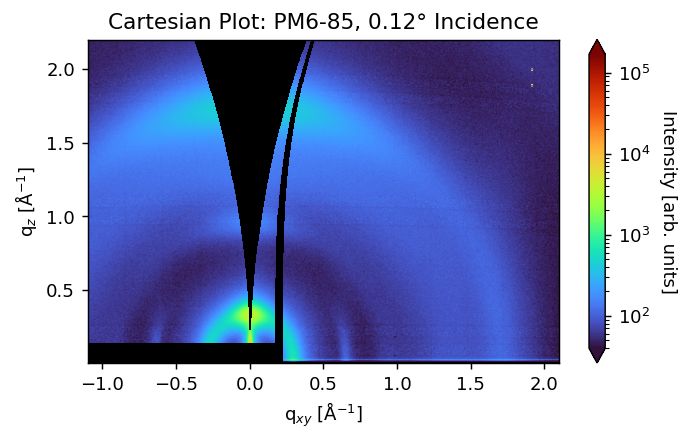

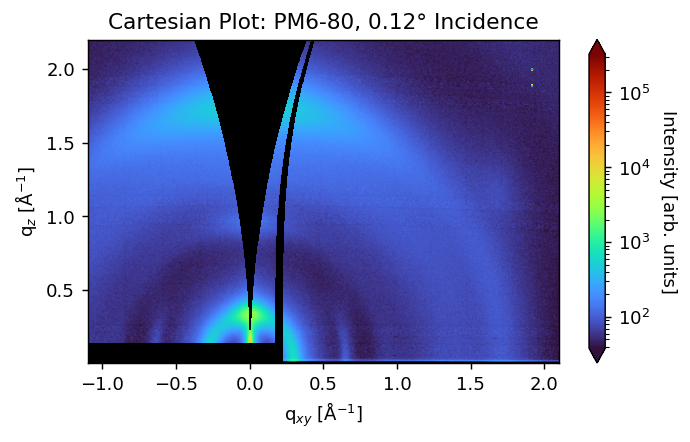

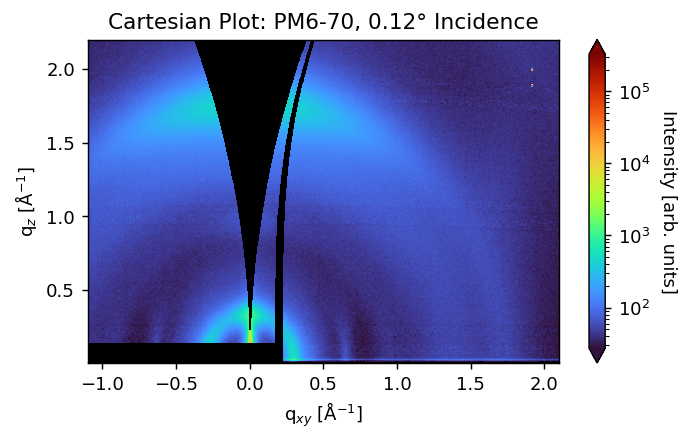

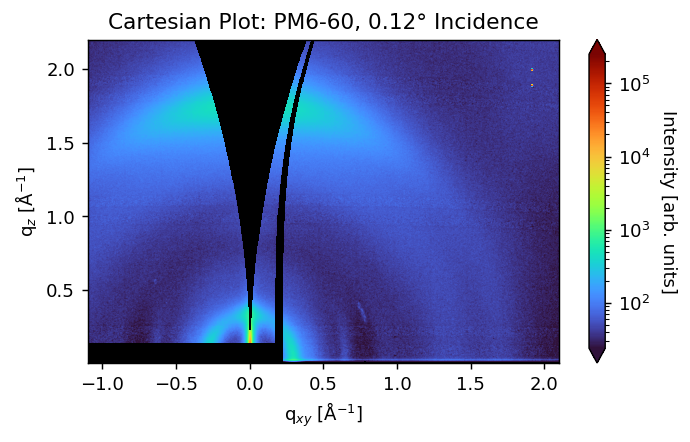

In [12]:
# Plot & optionally save each selected polymer:-{DA.weight_percent}
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(-1.1, 2.1), q_z=slice(0, 2.2))
    cmin = float(sliced_DA.compute().quantile(1e-2))
    cmax = float(sliced_DA.compute().quantile(1-1e-8))   
    
    # Same plotting procedure as above
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=LogNorm(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    ax.axes.set(aspect='equal', title=f'Cartesian Plot: {DA.polymer}-{DA.weight_percent}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.figure.set(tight_layout=True, dpi=130)
    
    # ax.figure.savefig(outPath.joinpath('PM6-Y6set_waxs', f'cartesian-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}.png'), dpi=150)
    plt.show()
    plt.close('all')

In [13]:
# # A way to save data as csv files
# for DA in tqdm(DS.data_vars.values()):
#     # qxy columns, qz rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'cartesian-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

### 1D Plots

In [14]:
filename = 'caked_PM6-Y6_waxs_stitched.zarr'
DS = xr.open_zarr(samplesPath.joinpath(filename))
DS = DS.where(DS>1e-5)
DS

<xarray.Dataset>
Dimensions:  (chi: 180, qr: 1000)
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.1393 0.1424 0.1455 0.1486 ... 3.226 3.229 3.232
Data variables: (12/18)
    1116469  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116470  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116471  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116475  (chi, qr) float32 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116476  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116477  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    ...       ...
    1116493  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116494  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116495  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116499  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116500  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116501  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>

In [15]:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['incident_angle'] == 'th0.120']
len(selected_DAs)

6

  0%|          | 0/6 [00:00<?, ?it/s]

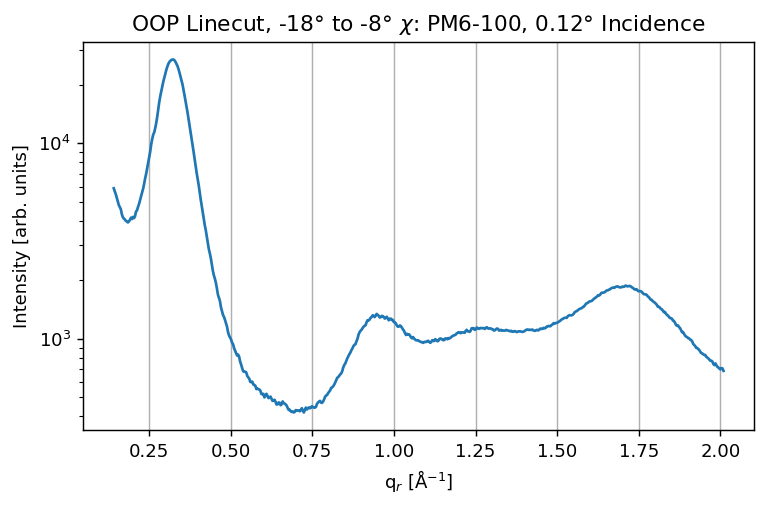

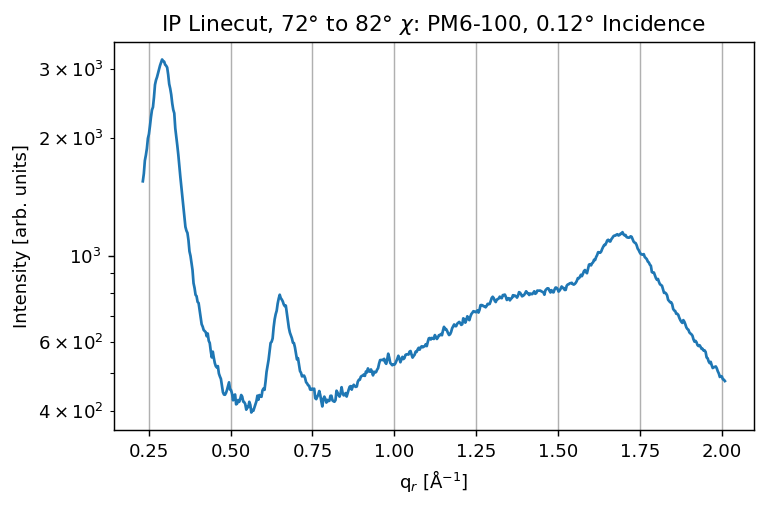

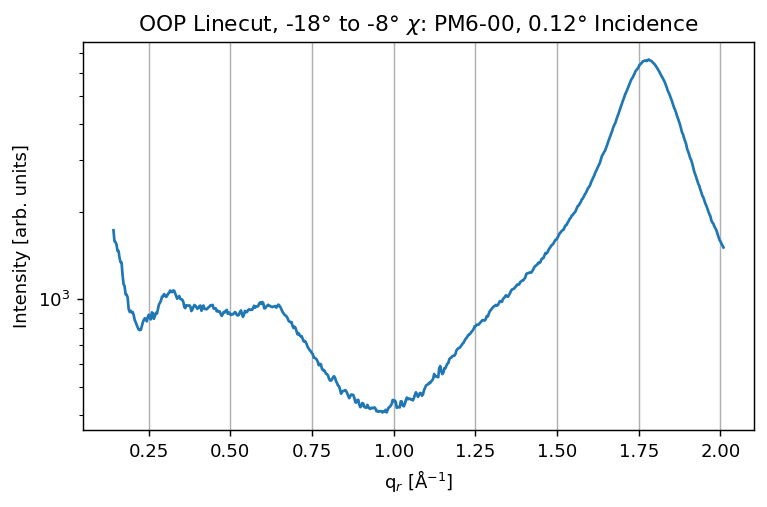

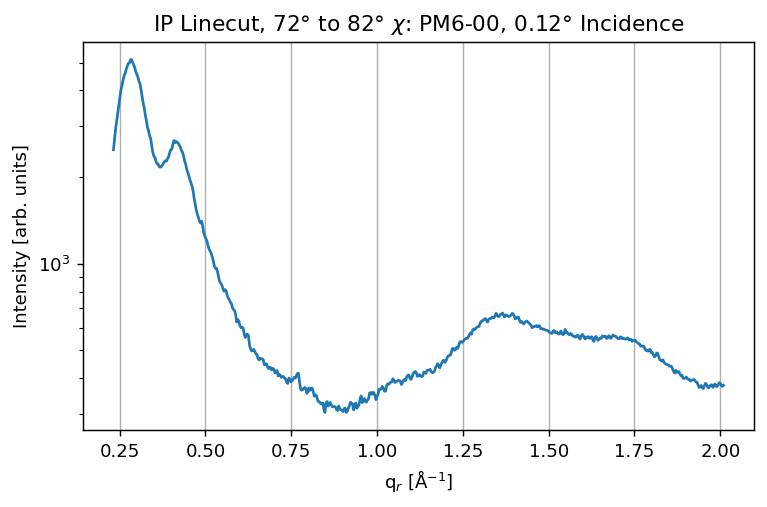

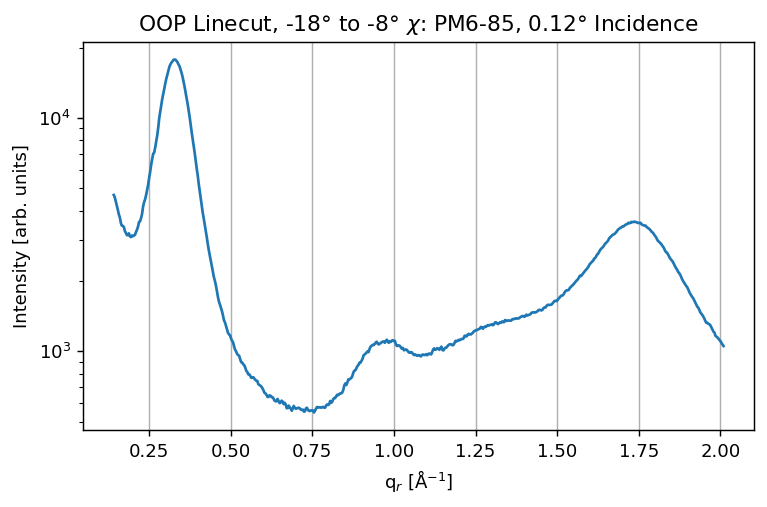

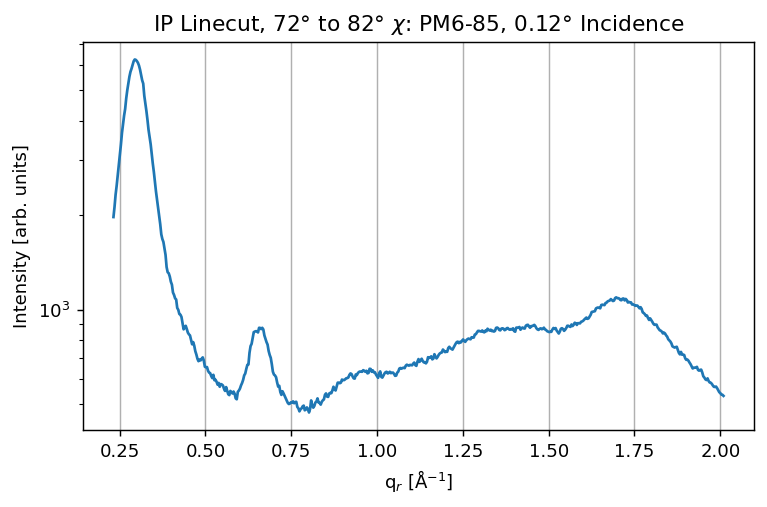

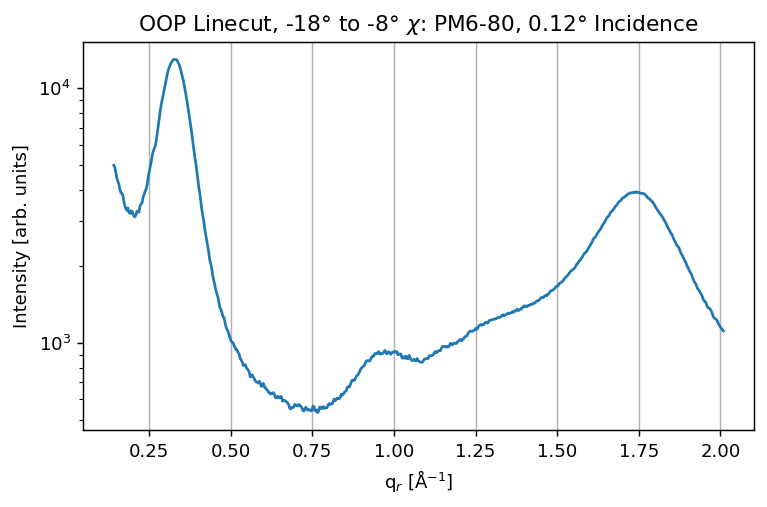

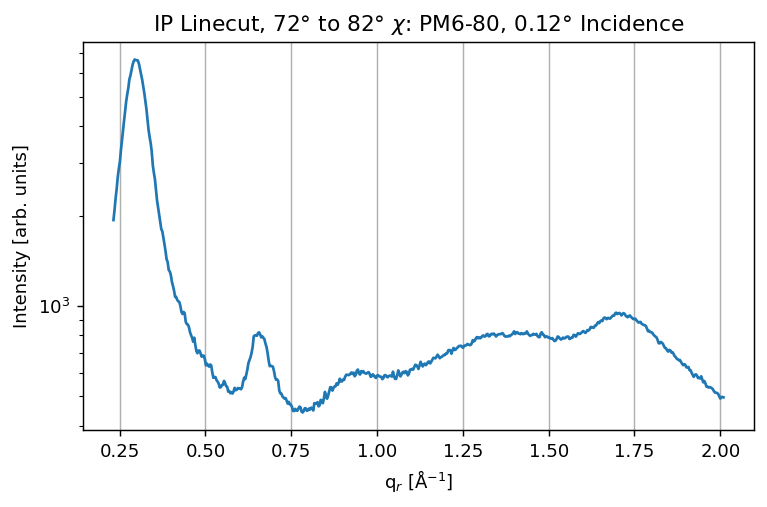

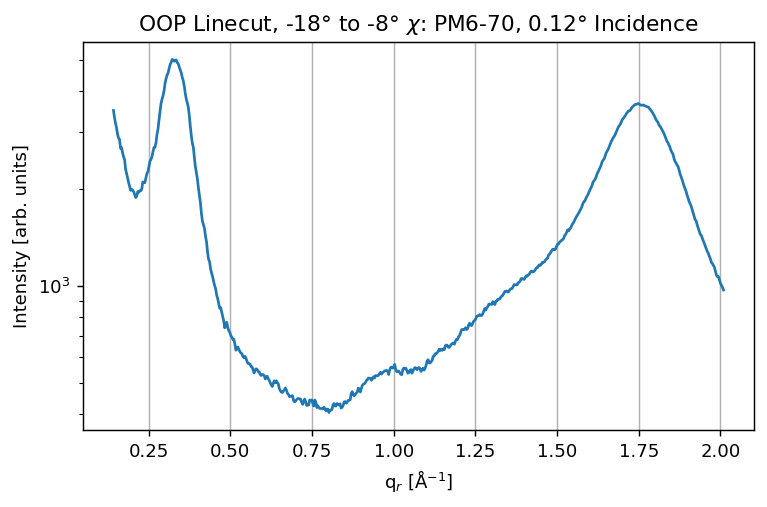

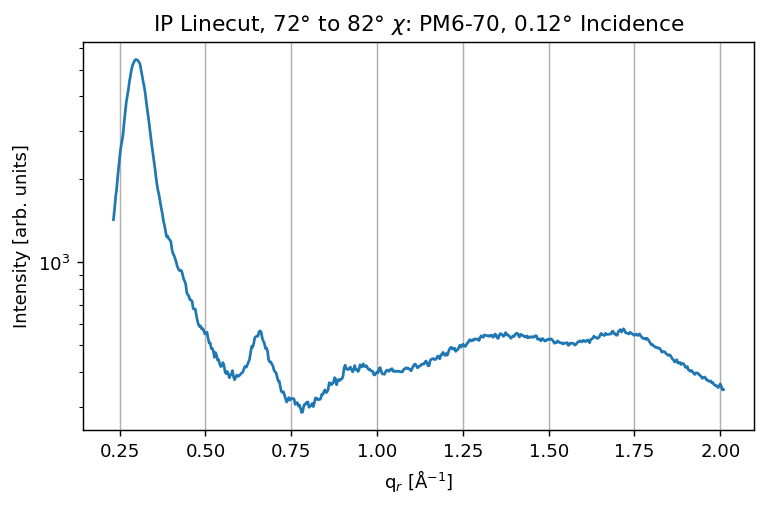

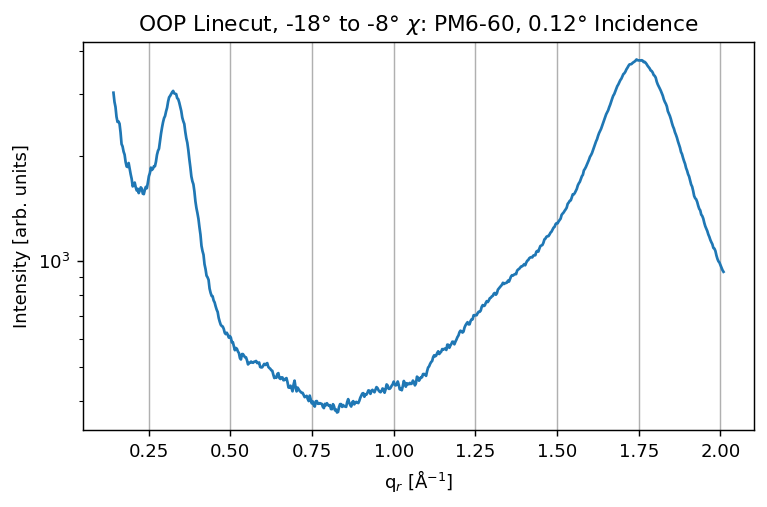

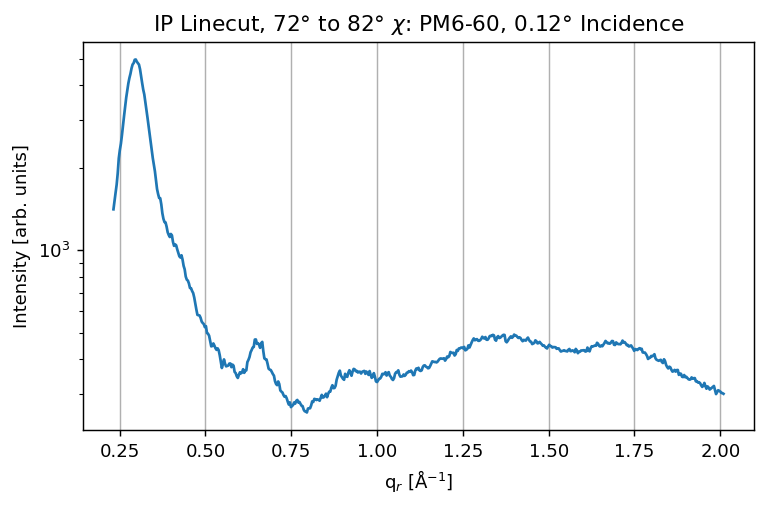

In [16]:
# Plot linecuts for selected chi ranges, here I've put both in plane and out of plane selections into the loop

for DA in tqdm(selected_DAs):
    # OOP
    chi_min = -18
    chi_max = -8
    DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.14,2.01)).sum('chi').plot.line(figsize=(6,4))

    # A plot.line xarray plot does not return an AxesImage object like imshow does, so I use plt.gca() and plt.gcf() to access the axes & figure parameters
    ax = plt.gca()
    fig = plt.gcf()
    
    ax.set(title=f'OOP Linecut, {chi_min}° to {chi_max}° $\chi$: {DA.polymer}-{DA.weight_percent}, {float(DA.incident_angle[2:])}° Incidence',
           yscale='log', ylabel='Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
    ax.grid(visible=True, which='major', axis='x')
    fig.set(tight_layout=True, dpi=130)
    
    plt.show()
    # fig.savefig(outPath.joinpath('PM6-Y6set_waxs', f'linecut_OOP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')
    
    # IP
    chi_min = 72
    chi_max = 82
    DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.23,2.01)).sum('chi').plot.line(figsize=(6,4))  
    
    ax = plt.gca()
    fig = plt.gcf()
    
    ax.set(title=f'IP Linecut, {chi_min}° to {chi_max}° $\chi$: {DA.polymer}-{DA.weight_percent}, {float(DA.incident_angle[2:])}° Incidence',
           yscale='log', ylabel='Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
    ax.grid(visible=True, which='major', axis='x')
    fig.set(tight_layout=True, dpi=130)
    
    plt.show()
    # fig.savefig(outPath.joinpath('PM6-Y6set_waxs', f'linecut_IP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')
    